In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "..")

In [3]:
from rehoused_nlp import build_nlp, visualize_doc_classification
from medspacy.visualization import visualize_ent, visualize_dep
from rehoused_nlp import calculate_rehoused

from helpers import ENT_COLORS

In [4]:
%%capture
nlp = build_nlp()

In [5]:
# !pip install matplotlib
# !pip install pandas

In [ ]:
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# 5. ReHouSED Patient-Level Score
The ultimate goal of this system is to describe a patient's current housing stability. NLP is used to extract information from individual documents, but this ultimately has to be aggregated to a patient level. This is challenging because different documents can contain conflicting information. These discrepancies could be due to:
- NLP errors
- Inconsistent documentation
- Actual changes in the patient housing situation (e.g., they were homeless but one week later found an apartment)

To do this, we developed the **Relative Housing Stability in Electronic Documentation (ReHouSED)** score. This is a simple calculation of the proportion of notes classified as stably housed out of all stably/unstably housed documents over a certain time period.

$$ \begin{equation} \label{label} ReHouSED = \frac{Stably Housed}{Stably Housed + Unstably Housed} \end{equation} $$

Note that this score discards documents classified as **"UNKNOWN"**, as these are deemed to not contain relevant information. 

In the manuscript, this score is calculated in discrete 30-day time windows at various intervals from a patient's discharge from SSVF, but other time windows/aggregation methods are possible and will be evaluated in the future.

To demonstrate how ReHouSED is calculated, we'll use a set of simple fictional texts over a course of ~90 days. In this narrative, the patient is evicted from her apartment, stays temporarily in a shelter, and eventually finds stable housing. The column **time_to_index** denotes the difference in days from the date the note was written to whatever the index date is. In this example, that date is the day the patient lost housing; in the manuscript, it's the date the patient exited SSVF.

In [ ]:
df = pd.read_csv("./example_rehoused_longitudinal.tsv", sep="\t")

In [ ]:
df

First, we'll process all of these documents with our NLP model:

In [10]:
docs = list(nlp.pipe(df["text"]))

In [11]:
df["doc"] = docs

In [12]:
df["document_classification"] = [doc._.document_classification for doc in docs]

Let's look at how each of these documents were processed. Notice that some examples may not exactly be correct, which could introduce some noise to our classification:

In [13]:
for i, row in df.iterrows():
    print("Time:", row["time_to_index"])
    visualize_doc_classification(row["doc"], colors=ENT_COLORS)
    print("----"*5)
    print()

Time: 0


--------------------

Time: 4


--------------------

Time: 12


--------------------

Time: 25


--------------------

Time: 30


--------------------

Time: 35


--------------------

Time: 45


--------------------

Time: 55


--------------------

Time: 60


--------------------

Time: 70


--------------------

Time: 80


--------------------

Time: 85


--------------------

Time: 90


--------------------

Time: 95


--------------------



The helper function `calculate_rehoused` will group the DataFrame into 30-day windows (or whatever time window is specified) and calculate the ReHouSED score at each time point. Because this is a simple step, you could also easily do this manually.

The resulting DataFrame contains a column specifying the time window, how many documents were classfied as **"STABLY_HOUSED"**, how many were classified as **"UNSTABLY_HOUSED"**, and the ReHouSED score calculated as the proportion. Note that although the input had 4 documents per time window, some documents were classified as **"UNKNOWN"** and dropped from the output.

In [14]:
rehoused = calculate_rehoused(df, window_size=30, patient_col="pt_id")

In [15]:
rehoused.head()

,pt_id,time_window,STABLY_HOUSED,UNSTABLY_HOUSED,total_documents,rehoused
0,1,0,0,4,4,0.000000
1,1,1,1,2,3,0.333333
2,1,2,2,1,3,0.666667
3,1,3,2,0,2,1.000000


The ReHouSED score can now be used to show a longitudinal representation of a patient's housing stability. If we plot the ReHouSED score over time, we can see the patient's change from homelessness to stable housing. 

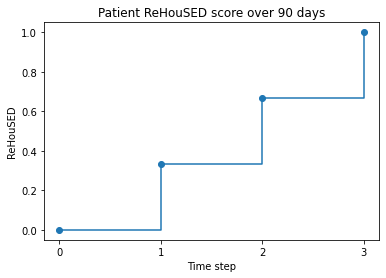

In [16]:
plt.step(rehoused["time_window"], rehoused["rehoused"], marker="o", where="post")

plt.xticks([0, 1, 2, 3])
plt.xlabel("Time step")
plt.ylabel("ReHouSED")
plt.title("Patient ReHouSED score over 90 days");

This aggregation method allows for variation between documents. A patient with a large number of documents will likely have a more consistent and correct ReHouSED score. And calculating the ReHouSED score for a large number of patients may be used to do population-level analysis. Future work will look more at how to interpret this score and use it for population-level analysis.